# LSTM Model with GridSearchCV + Holdout

### Import Packages

In [ ]:
# os.environ['PYTHONHASHSEED'] = '1'

np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import time




# tensorflow + keras packages
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

# sklearn packages
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score


import seaborn as sns
import matplotlib.pyplot as plt



# stop words and lem package
import re
import nltk

from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')



import warnings
warnings.filterwarnings('ignore')


# Gets the current working directory
current_directory = os.getcwd()

# Set a relative path
relative_path = os.path.join(os.pardir, os.pardir, "Dataset PPT Report", "Metadata Labeled.csv")

# Use os.path.join to combine the current directory with a relative path to create a complete file path
full_path = os.path.join(current_directory, relative_path)

# Read CSV file
df = pd.read_csv(full_path)

# df = pd.read_csv('Metadata - Labeled.csv')


### Preprocessing

In [125]:
def clean_text(text):
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = text.lower().translate(str.maketrans('', '', punctuation))
    return text

def stopwords_and_lemmatize(text):
    words = [word for word in text.split() if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Clean and preprocess 'Title', 'Trace', and 'Processed Text' columns
df['Title'] = df['Title'].apply(clean_text).apply(stopwords_and_lemmatize)
df['Trace'] = df['Trace'].apply(clean_text).apply(stopwords_and_lemmatize)
df['Processed Text'] = df['Processed Text'].apply(stopwords_and_lemmatize)

# appended
df['Combined'] = df['Processed Text'] + ' ' + df['Title'] + ' ' + df['Trace']

X = df[['Combined', 'Title', 'Trace']]
y = df['Good']

# Print the head of the updated dataframe
df = df[['Processed Text','Combined', 'Title', 'Trace', 'Good']]
df.head(10)

,Processed Text,Combined,Title,Trace,Good
0,sec 10 5 4 authority general manager departmen...,sec 10 5 4 authority general manager departmen...,sec 10 5 4 authority general manager departmen...,los angeles overview los angeles charter admin...,False
1,sec 10 51 purpose november 2016 voter city los...,sec 10 51 purpose november 2016 voter city los...,sec 10 51 purpose,los angeles overview los angeles charter admin...,False
2,sec 10 51 1 definition following definition sh...,sec 10 51 1 definition following definition sh...,sec 10 51 1 definition,los angeles overview los angeles charter admin...,False
3,sec 10 51 10 coexistence available relief spec...,sec 10 51 10 coexistence available relief spec...,sec 10 51 10 coexistence available relief spec...,los angeles overview los angeles charter admin...,False
4,sec 10 51 11 severability court competent juri...,sec 10 51 11 severability court competent juri...,sec 10 51 11 severability,los angeles overview los angeles charter admin...,False
5,sec 10 51 3 targeted hiring hhh pla shall incl...,sec 10 51 3 targeted hiring hhh pla shall incl...,sec 10 51 3 targeted hiring,los angeles overview los angeles charter admin...,False
6,sec 10 51 4 outreach training daa provide educ...,sec 10 51 4 outreach training daa provide educ...,sec 10 51 4 outreach training,los angeles overview los angeles charter admin...,False
7,sec 10 51 5 administration hhh pla shall admin...,sec 10 51 5 administration hhh pla shall admin...,sec 10 51 5 administration,los angeles overview los angeles charter admin...,False
8,sec 10 51 6 enforcement daa determines contrac...,sec 10 51 6 enforcement daa determines contrac...,sec 10 51 6 enforcement,los angeles overview los angeles charter admin...,False
9,sec 10 51 7 exemption following contract exemp...,sec 10 51 7 exemption following contract exemp...,sec 10 51 7 exemption,los angeles overview los angeles charter admin...,False


Preprocessing was done to the "Trace" and "Title" just as how it was done for "Processed Text" how it was done previously when putting all HTML files in metadata. The same preprocessing technique was applied to our selected features as well to remain consistency.

### Data Split

In [126]:
# split the dataset, stratified by the label column
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=1)


# print the number of samples in each set
print('Number of samples in training set:', len(X_train))
print('Number of samples in validation set:', len(X_val))
print('Number of samples in testing set:', len(X_test))

Number of samples in training set: 453
Number of samples in validation set: 152
Number of samples in testing set: 152


The dataset was split into training, validation, and testing sets for our GridSearchCV and Holdout that is later executed. Stratify was used on the target (y) dataset

### Target Variable Encoding

In [127]:
# Label encode the "GOOD" column
le = LabelEncoder()
y_train_val = le.fit_transform(y_train_val)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# print the number of samples in each set
print('Number of samples in y training validation set:', len(y_train_val))
print('Number of samples in y training set:', len(y_train))
print('Number of samples in y validation set:', len(y_val))
print('Number of samples in y testing set:', len(y_test))




Number of samples in y training validation set: 605
Number of samples in y training set: 453
Number of samples in y validation set: 152
Number of samples in y testing set: 152


LabelEncoder is also used to transform the label variable, "GOOD",  where the 'True' becomes 0 and 'False" becomes 1.

### Tokenization 

In [ ]:
# title_lengths = X_train['Title'].apply(lambda x: len(x.split()))
trace_lengths = X_train['Trace'].apply(lambda x: len(x.split()))


# Determine maxlen for 'Title'
maxlen_title = int(np.percentile(title_lengths, 95))
print(f"Maxlen for Title (95th percentile): {maxlen_title}")

# Determine maxlen for 'Trace'
maxlen_trace = int(np.percentile(trace_lengths, 95))
print(f"Maxlen for Trace (95th percentile): {maxlen_trace}")

# 
sequence_lengths = X_train['Combined'].apply(lambda x: len(x.split()))


print(f"Max length: {np.max(sequence_lengths)}")

# Determine maxlen
maxlen_combined = int(np.percentile(sequence_lengths, 95))  # 95th percentile
print(f"Maxlen for Combined (95th percentile): {maxlen_combined}")




tokenizer_combined = Tokenizer(num_words=10000)
tokenizer_combined.fit_on_texts(X_train['Combined'])

tokenizer_title = Tokenizer(num_words=10000)
tokenizer_title.fit_on_texts(X_train['Title'])

tokenizer_trace = Tokenizer(num_words=10000)
tokenizer_trace.fit_on_texts(X_train['Trace'])


# Tokenize and pad the sequences using the appropriate maxlen values
X_train_combined_vec = pad_sequences(tokenizer_combined.texts_to_sequences(X_train['Combined']), padding = 'pre', maxlen=maxlen_combined)
X_train_title_vec = pad_sequences(tokenizer_title.texts_to_sequences(X_train['Title']), padding = 'pre',  maxlen=maxlen_title)
X_train_trace_vec = pad_sequences(tokenizer_trace.texts_to_sequences(X_train['Trace']), padding = 'pre', maxlen=maxlen_trace)

X_val_combined_vec = pad_sequences(tokenizer_combined.texts_to_sequences(X_val['Combined']),padding = 'pre', maxlen=maxlen_combined)
X_val_title_vec = pad_sequences(tokenizer_title.texts_to_sequences(X_val['Title']), padding = 'pre', maxlen=maxlen_title)
X_val_trace_vec = pad_sequences(tokenizer_trace.texts_to_sequences(X_val['Trace']), padding = 'pre', maxlen=maxlen_trace)

X_test_combined_vec = pad_sequences(tokenizer_combined.texts_to_sequences(X_test['Combined']),  padding = 'pre', maxlen=maxlen_combined)
X_test_title_vec = pad_sequences(tokenizer_title.texts_to_sequences(X_test['Title']), padding = 'pre', maxlen=maxlen_title)
X_test_trace_vec = pad_sequences(tokenizer_trace.texts_to_sequences(X_test['Trace']), padding = 'pre', maxlen=maxlen_trace)


Tokenizer was used to convert text to numerical values for the model; text_to_sequence. pad_sequences was used to ensure proper shaping of input data.

### Obtain Vocab Size

In [129]:
# Add 1 to account for the out-of-vocabulary (OOV) token
vocab_size_combined = len(tokenizer_combined.word_index) + 1
print(f"Vocabulary size for Combined: {vocab_size_combined}")


# Add 1 to account for the out-of-vocabulary (OOV) token
vocab_size_title = len(tokenizer_title.word_index) + 1
print(f"Vocabulary size for Title: {vocab_size_title}")

vocab_size_trace = len(tokenizer_trace.word_index) + 1
print(f"Vocabulary size for Trace: {vocab_size_trace}")


Vocabulary size for Combined: 5725
Vocabulary size for Title: 833
Vocabulary size for Trace: 438


Defining vocab size for each selected feature to later use in LSTM model.

### Model Deployment

In [130]:
# Record the start time
start_time = time.time()

def lstm_model(lstm_units=128, dense_units=64):
    input_layer = Input(shape=(maxlen_combined + maxlen_title + maxlen_trace,), name="input_layer")

    # Separate embedding layers for each vocabulary
    embedding_combined = Embedding(vocab_size_combined, 100, input_length=maxlen_combined)
    embedding_title = Embedding(vocab_size_title, 100, input_length=maxlen_title)
    embedding_trace = Embedding(vocab_size_trace, 100, input_length=maxlen_trace)

    # Embed the inputs using the respective embedding layers
    embedded_combined = embedding_combined(input_layer[:, :maxlen_combined])
    embedded_title = embedding_title(input_layer[:, maxlen_combined:maxlen_combined + maxlen_title])
    embedded_trace = embedding_trace(input_layer[:, -maxlen_trace:])

    lstm_combined = LSTM(lstm_units)(embedded_combined)
    dropout_combined = Dropout(0.2)(lstm_combined) 

    lstm_title = LSTM(lstm_units)(embedded_title)

    lstm_trace = LSTM(lstm_units)(embedded_trace)

    concatenated = concatenate([dropout_combined, lstm_title, lstm_trace])

    dense = Dense(dense_units, activation="relu")(concatenated)
    dropout = Dropout(0.2)(dense)
    output = Dense(1, activation="sigmoid")(dropout)


    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Use the KerasClassifier wrapper
model = KerasClassifier(build_fn=lstm_model, epochs=10, batch_size=64, verbose=0)



param_grid = {
    "lstm_units": [50,128],
    "dense_units": [16, 32, 64]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(
    np.hstack([X_train_combined_vec, X_train_title_vec, X_train_trace_vec]),
    y_train,
    validation_data=(np.hstack([X_val_combined_vec, X_val_title_vec, X_val_trace_vec]), y_val),
    verbose=1
)


print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


print("")

best_model = grid_result.best_estimator_


# Make predictions for the test set
y_test_pred = best_model.predict(np.hstack([X_test_combined_vec, X_test_title_vec, X_test_trace_vec]))

# test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("")
# confusion matrix, classification report, and AUC-ROC
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm_test)

cr_test = classification_report(y_test, y_test_pred, target_names=['False', 'True'])
print("Classification Report:")
print("")
print(cr_test)
print("")
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"AUC-ROC: {roc_auc_test}")
print("")
# Calculate the ROC curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Epoch 1/10
4/4 [==============================] - 7s 724ms/step - loss: 0.6769 - accuracy: 0.7920 - val_loss: 0.6367 - val_accuracy: 0.8618
Epoch 2/10
4/4 [==============================] - 2s 507ms/step - loss: 0.6111 - accuracy: 0.8628 - val_loss: 0.5483 - val_accuracy: 0.8618
Epoch 3/10
4/4 [==============================] - 2s 495ms/step - loss: 0.5094 - accuracy: 0.8628 - val_loss: 0.4234 - val_accuracy: 0.8618
Epoch 4/10
4/4 [==============================] - 2s 469ms/step - loss: 0.4074 - accuracy: 0.8628 - val_loss: 0.3732 - val_accuracy: 0.8618
Epoch 5/10
4/4 [==============================] - 2s 477ms/step - loss: 0.3490 - accuracy: 0.8628 - val_loss: 0.3418 - val_accuracy: 0.8618
Epoch 6/10
4/4 [==============================] - 2s 487ms/step - loss: 0.2886 - accuracy: 0.8628 - val_loss: 0.3024 - val_accuracy: 0.8618
Epoch 7/10
4/4 [==============================] - 2s 488ms/step - loss: 0.2505 - accuracy: 0.8628 - val_loss: 0.2563 - val_accuracy: 0.8618
Epoch 8/10
4/4 [====

The LSTM model above has three total layers for embedding and LSTM layers for each feature. The parameters lstm_units and dense_units were chosen through the process of hypertuning. These units had proven to give an excellent output. There are two dropout layers, and this is to prevent overfitting in the lstm_combined layer as well as the others. Dropout unit of 0.2 had proven to be better than 0.5. A GridSearchCV was then performed on the entire model where we then selected default values for cv:

param_grid = {
    "lstm_units": [50,128],
    "dense_units": [16, 32, 64]
}


### Results

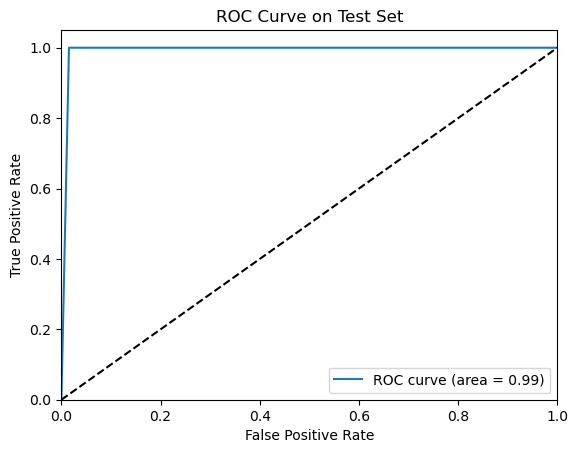

In [131]:
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"ROC curve (area = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend(loc="lower right")
plt.show()


ROC Curve indicates near perfect performance

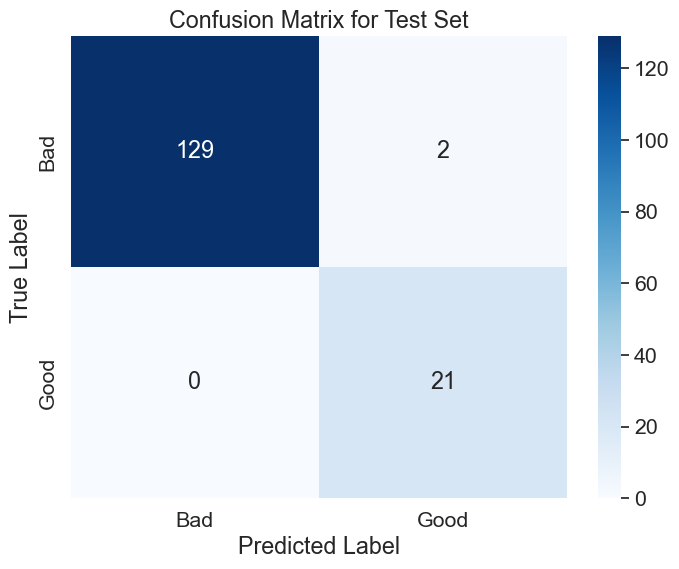

In [137]:
def confusion_matrix(cm_test, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix for Test Set')
    plt.show()
# Plot the confusion matrix
confusion_matrix(cm_test, ['Bad', 'Good'])



Looking at the confusion matrix for the Test Set, we can see how the model performed, we see there is a total of 152 samples. And 129 out of those are true negatives meaning the model has correctly predicted the
negative class, we have 2 false positives where the model has incorrectly predicted the positive class when it was actually negative, we have 0 false negative where the model has incorrectly predicted the negative class when it is actually positive, and finally 21 true positives where the model has correctly predicted the good classes. The overall number of good classes is 21, and the model had correctly identified 21 of those which indicates excellent model performance.

5/5 [==============================] - 0s 75ms/step
Validation Accuracy: 0.9473684210526315

Validation Set Confusion Matrix:
[[128   3]
 [  5  16]]


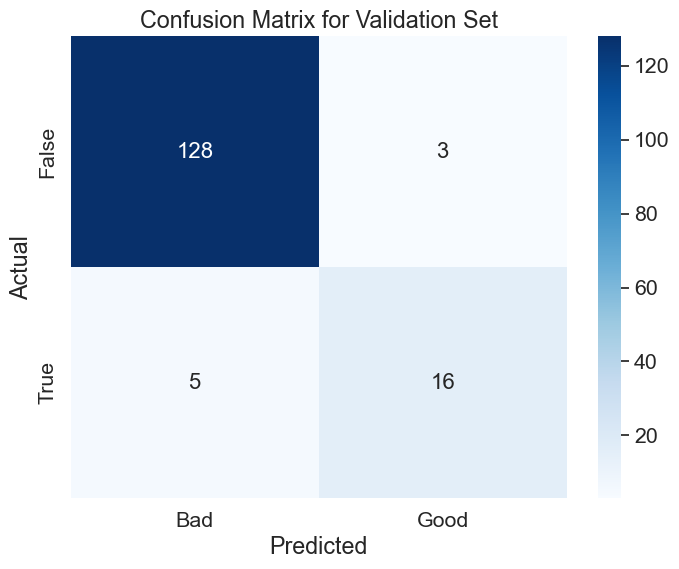

In [138]:
# validation set predicts 
y_val_pred = best_model.predict(np.hstack([X_val_combined_vec, X_val_title_vec, X_val_trace_vec]))

# Calculate the validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("")

# confusion matrix for the validation set
cm_val = confusion_matrix(y_val, y_val_pred)


# Plot the confusion matrix 
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) 
sns.heatmap(cm_val, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt="d", xticklabels=["Bad", "Good"], yticklabels=["False", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Validation Set")
plt.show()

Looking at the confusion matrix for the Validation Set, the results are a bit dissimilar to our previous results. 128 samples were correctly predicted as negative class, we have 3 false positives where the model has incorrectly predicted the positive class when it was actually negative, we have 5 false negative where the model has incorrectly predicted the negative class when it is actually positive, and finally 16 true
positives where the model has correctly predicted the good classes. The overall number of good classes is 21, and the model had correctly identified 16 of those which indicates the model does generalize good enough on
the dataset but there is room for improvement in hyperparameter tuning or having a largescaled data to train the model on.

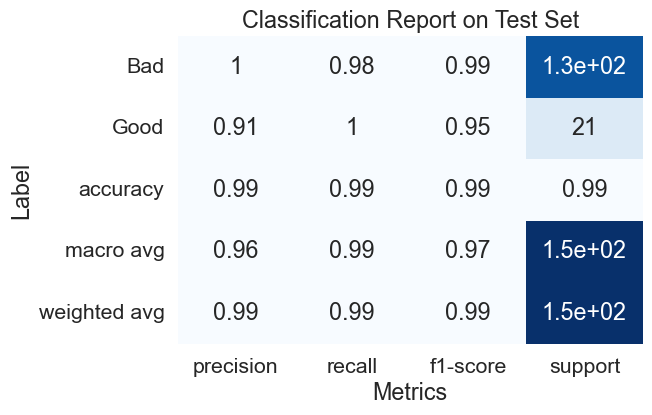

In [142]:
def classification_report(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # put the actual labels to 'True' and 'False' 
    index_mapper = {str(labels[0]): 'Bad', str(labels[1]): 'Good', 'accuracy': 'accuracy', 'macro avg': 'macro avg', 'weighted avg': 'weighted avg'}
    report_df.rename(index=index_mapper, inplace=True)
    
    report_df = report_df.round(2)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(report_df, annot=True, cmap='Blues', cbar=False, xticklabels=True, yticklabels=True)
    plt.yticks(rotation=0)
    plt.xlabel('Metrics')
    plt.ylabel('Label')
    plt.title('Classification Report on Test Set')
    plt.show()

classification_report(y_test, y_test_pred, [0, 1])


This figure is a classification report for the Test Set. We can just focus on the accuracy and precision since that is what matters most. Precision is our correctly predicted good, recall
is predicted good out of actual good. F1 score is the average of precision and recall. We can see the overall
accuracy is 99% with 91% precision for the Good class. This figure suggests the model has a very strong performance overall, and can accurately predict between “Good” and “Bad” classes.

### Validation & Training Accuracy + Precision

In [140]:
def accuracy_precision(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    print(f"{dataset_name} Accuracy: {accuracy}")
    print(f"{dataset_name} Precision: {precision}")


# training set
y_train_pred = best_model.predict(np.hstack([X_train_combined_vec, X_train_title_vec, X_train_trace_vec]))
accuracy_precision(y_train, y_train_pred, "Training")

# validation set
y_val_pred = best_model.predict(np.hstack([X_val_combined_vec, X_val_title_vec, X_val_trace_vec]))
accuracy_precision(y_val, y_val_pred, "Validation")


15/15 [==============================] - 1s 72ms/step
Training Accuracy: 1.0
Training Precision: 1.0
5/5 [==============================] - 0s 69ms/step
Validation Accuracy: 0.9473684210526315
Validation Precision: 0.8421052631578947


### Recommendations for QQ Tech

When testing more features in this LSTM model, be sure to obtain maxlen/vocab size for each feature. Furthermore, any additional layer need their own embedding and LSTM layer; add dropout where necessary. The HTML Cleaner + Add to Metadata.py uploaded onto GitHub is a code that takes all HTML files from categorical folder and appropriately puts the text in a seperate column labeled "Processed Text" by matching filename. To save the extra step in the preprocessing, precleaning the HTML files can be deleted from the HTML Cleaner and preprocessing can be done to ALL features all at once using the code all the way at the top; this saves time and that extra step that can easily be avoided. 

### Challenges Faced

One major challenge that I had faced towards the end is regarding the end results. The end results would change after every run. Things I had tried but did not work:

os.environ['PYTHONHASHSEED'] = '1'

np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)

